<a href="https://colab.research.google.com/github/stellasdeutsch-dev/1dcnn/blob/main/Traffic_Flow_Prediction_with_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Dataset loaded. Shape: (12883, 207)
   Missing values after cleaning: 0
   (Rows: Time steps, Columns: Sensors)

2. Preprocessing data...
   Sequences created. X shape: (12871, 12, 207), y shape: (12871, 207)

3. Data Splitting (Strict Time-Series Split):
   Training Set (First 80%): 10296 samples
   Testing Set  (Last 19%):  2575 samples

4. Building and Training Model...
Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2167 - mae: 0.3358 - val_loss: 0.0354 - val_mae: 0.1322
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0431 - mae: 0.1490 - val_loss: 0.0268 - val_mae: 0.0944
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0349 - mae: 0.1286 - val_loss: 0.0247 - val_mae: 0.0907
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0314 - mae: 0.1212 - val_loss: 0.0246 - val_mae: 0.0947
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0281 - mae: 0.1129 - val_loss: 0.0234 - val_mae: 0.0839
Epoch 6/20
161/161 ━━━━━━━

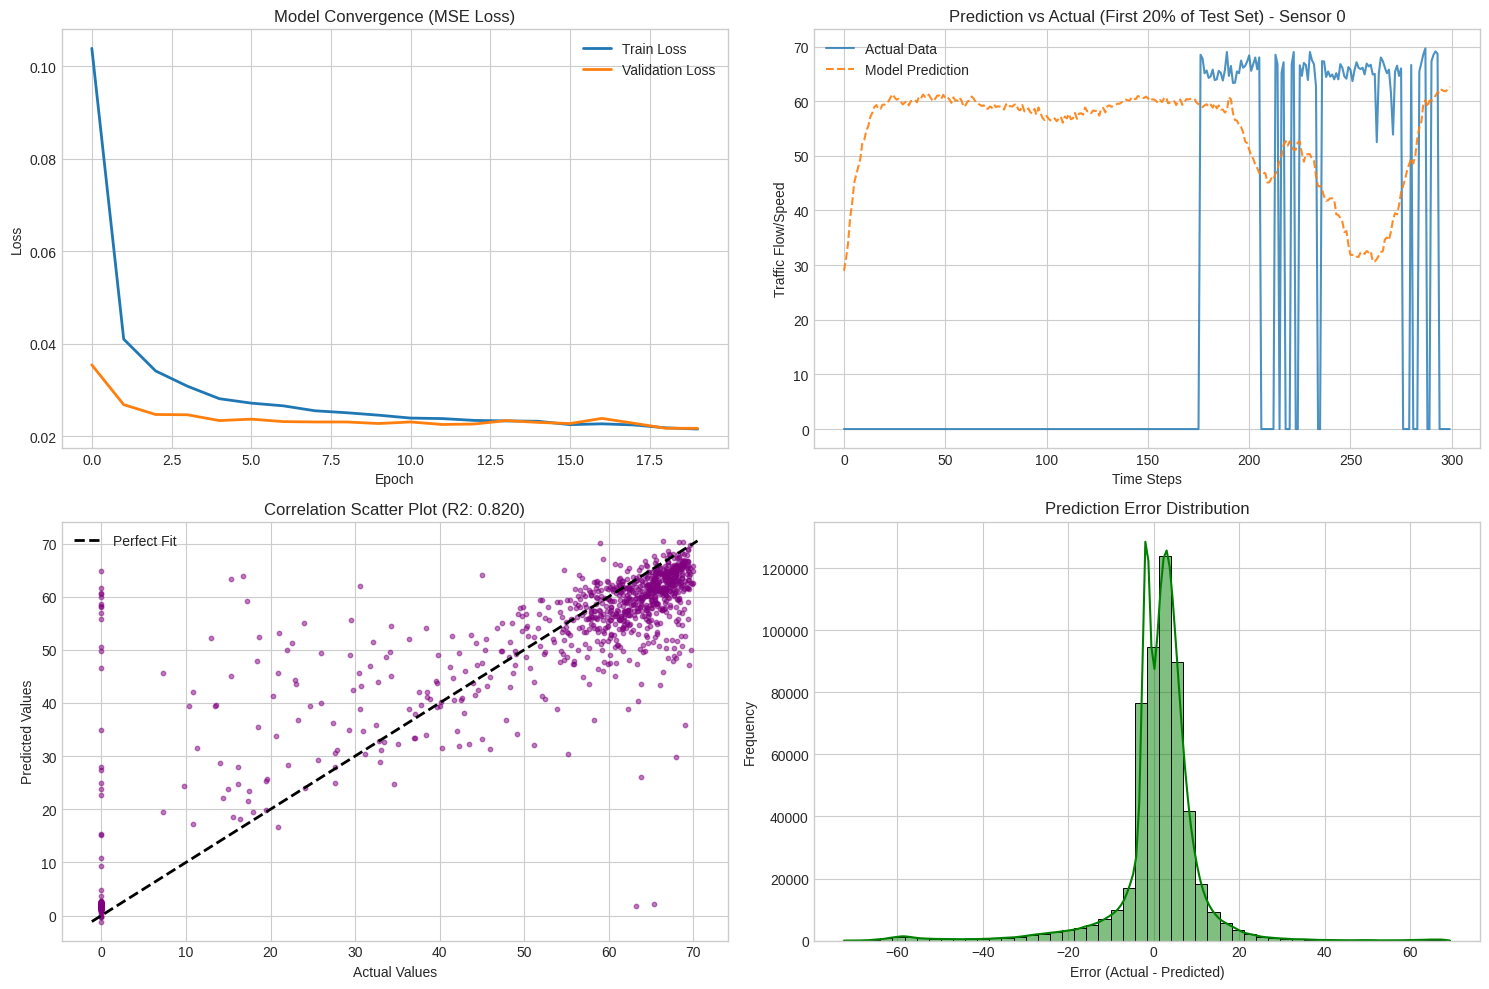

Process Complete.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def load_data(filepath):
    """
    Loads the traffic data from CSV and handles missing values.
    """
    if not os.path.exists(filepath):
        print(f"Error: File '{filepath}' not found.")
        return None

    df = pd.read_csv(filepath, index_col=0)

    # Check if index is datetime-like for plotting
    try:
        df.index = pd.to_datetime(df.index)
    except:
        pass

    # --- CRITICAL FIX: Handle Missing Values ---
    # Real-world data often has gaps. We fill NaNs to prevent model crashes.
    # ffill() propagates the last valid observation forward.
    # fillna(0) catches any remaining NaNs at the start.
    df = df.ffill().fillna(0)

    print(f"1. Dataset loaded. Shape: {df.shape}")
    print(f"   Missing values after cleaning: {df.isnull().sum().sum()}")
    print("   (Rows: Time steps, Columns: Sensors)")
    return df

def create_sequences(data, window_size, horizon=1):
    """
    Creates input sequences (X) and target values (y).
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

def build_cnn_model(input_shape, output_dim):
    """
    Builds the 1D CNN model.
    """
    model = Sequential([
        # Updated to use Input layer to avoid Keras warnings
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(output_dim)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def calculate_metrics(y_true, y_pred):
    """
    Calculates comprehensive performance metrics.
    """
    # Safety check for NaNs in predictions
    if np.isnan(y_pred).any():
        print("Warning: NaNs found in predictions. Replacing with 0 for metric calculation.")
        y_pred = np.nan_to_num(y_pred)

    # Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    # R2 Score (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)

    # Mean Absolute Percentage Error (handle division by zero)
    # Add a small epsilon to avoid div by zero if values are 0
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R2 Score": r2
    }

def main():
    # --- Configuration ---
    FILE_PATH = 'METR-LA.csv'
    WINDOW_SIZE = 12
    BATCH_SIZE = 64
    EPOCHS = 20
    TRAIN_SPLIT = 0.80  # First 80% for training

    # 1. Load Data
    df = load_data(FILE_PATH)
    if df is None:
        return

    # Use a subset for faster demonstration if dataset is huge
    # df = df.iloc[:5000]

    values = df.values
    num_sensors = values.shape[1]

    print("\n2. Preprocessing data...")
    # Normalize Data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(values)

    # Create Sequences
    X, y = create_sequences(scaled_data, WINDOW_SIZE)
    print(f"   Sequences created. X shape: {X.shape}, y shape: {y.shape}")

    # 3. Split into Train (First 80%) and Test (Remaining 20%)
    split_idx = int(len(X) * TRAIN_SPLIT)

    X_train = X[:split_idx]
    y_train = y[:split_idx]

    X_test = X[split_idx:]
    y_test = y[split_idx:]

    print(f"\n3. Data Splitting (Strict Time-Series Split):")
    print(f"   Training Set (First {int(TRAIN_SPLIT*100)}%): {X_train.shape[0]} samples")
    print(f"   Testing Set  (Last {int((1-TRAIN_SPLIT)*100)}%):  {X_test.shape[0]} samples")

    # 4. Build and Train Model
    print("\n4. Building and Training Model...")
    model = build_cnn_model(input_shape=(WINDOW_SIZE, num_sensors), output_dim=num_sensors)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # 5. Prediction
    print("\n5. Generating predictions on the 20% Test Set...")
    y_pred_scaled = model.predict(X_test)

    # Inverse transform to get actual units (e.g., speed/flow)
    y_test_actual = scaler.inverse_transform(y_test)
    y_pred_actual = scaler.inverse_transform(y_pred_scaled)

    # 6. Analytics & Table
    print("\n6. Calculating Analytics...")
    # We calculate metrics based on the flattened arrays (overall performance across all sensors)
    metrics = calculate_metrics(y_test_actual, y_pred_actual)

    # Create a DataFrame for the table
    metrics_df = pd.DataFrame([metrics])

    print("\n" + "="*40)
    print("FINAL ANALYTICS TABLE (TEST SET)")
    print("="*40)
    print(metrics_df.round(4).to_string(index=False))
    print("="*40 + "\n")

    # 7. Visualization
    print("7. Generating Graphs...")

    # Set up the plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(15, 10))

    # Graph A: Training Loss
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Model Convergence (MSE Loss)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Graph B: Time Series Comparison (First Sensor)
    # We select the first sensor to visualize the time-series prediction
    sensor_idx = 0
    plot_len = 300 # Visualize first 300 steps of the test set for clarity

    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(y_test_actual[:plot_len, sensor_idx], label='Actual Data', color='#1f77b4', alpha=0.8)
    ax2.plot(y_pred_actual[:plot_len, sensor_idx], label='Model Prediction', color='#ff7f0e', linestyle='--', alpha=0.9)
    ax2.set_title(f'Prediction vs Actual (First 20% of Test Set) - Sensor {sensor_idx}')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Traffic Flow/Speed')
    ax2.legend()

    # Graph C: Scatter Plot (Overall Correlation)
    # Sample random points to avoid overplotting if dataset is huge
    sample_indices = np.random.choice(y_test_actual.flatten().shape[0], 1000, replace=False)
    y_true_sample = y_test_actual.flatten()[sample_indices]
    y_pred_sample = y_pred_actual.flatten()[sample_indices]

    ax3 = plt.subplot(2, 2, 3)
    ax3.scatter(y_true_sample, y_pred_sample, alpha=0.5, s=10, color='purple')
    # Perfect prediction line
    min_val = min(y_true_sample.min(), y_pred_sample.min())
    max_val = max(y_true_sample.max(), y_pred_sample.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Fit')
    ax3.set_title(f'Correlation Scatter Plot (R2: {metrics["R2 Score"]:.3f})')
    ax3.set_xlabel('Actual Values')
    ax3.set_ylabel('Predicted Values')
    ax3.legend()

    # Graph D: Error Distribution Histogram
    errors = y_test_actual - y_pred_actual
    errors_flat = errors.flatten()

    ax4 = plt.subplot(2, 2, 4)
    sns.histplot(errors_flat, bins=50, kde=True, ax=ax4, color='green')
    ax4.set_title('Prediction Error Distribution')
    ax4.set_xlabel('Error (Actual - Predicted)')
    ax4.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    print("Process Complete.")

if __name__ == "__main__":
    main()